In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

import nbodykit.lab as nb

import mpl_scatter_density
# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Matplotlib darkmode + color picker 
plt.style.use('dark_mode')


import yaml
import io


### Open Config File

In [2]:
# Read YAML file
with open("../config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
    
config

{'run_name': 'density_cube_snap_099_full_1024_all_species',
 'input_directory': '/global/cscratch1/sd/james12/Illustris_TNG_Data/TNG_Density_Cubes/',
 'snapfile_root': 99,
 'num_snaps': 1,
 'output_directory': '/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/',
 'xmin': 0.0,
 'xmax': 205000.0,
 'num_scales': 10,
 'nx': 1024,
 'DM_particle_mass_TNG': 0.00398342749867548,
 'GAS_particle_mass_TNG': 0.000743736,
 'DM_particle_mass_Dark': 0.0047271638660809,
 'N_DM': 15625000000,
 'N_GAS': 15625000000,
 'algorithm': 'NEXUS+',
 'simulation_type': 'All'}

# Read in Structure Filters

In [3]:
density_cube = np.load(config["input_directory"] + config["run_name"] + ".npy")

clusbool = np.load(config["output_directory"] + config["run_name"] + "_cluster_bool_filter.npy")
filbool = np.load(config["output_directory"] + config["run_name"] + "_filament_bool_filter.npy")
wallbool = np.load(config["output_directory"] + config["run_name"] + "_wall_bool_filter.npy")


In [4]:
filtered_clus = density_cube
filtered_clus = filtered_clus * clusbool.astype(int)
del clusbool

filtered_fil = density_cube
filtered_fil = filtered_fil * filbool.astype(int)
del filbool

filtered_wall = density_cube
filtered_wall = filtered_wall * wallbool.astype(int)
del wallbool

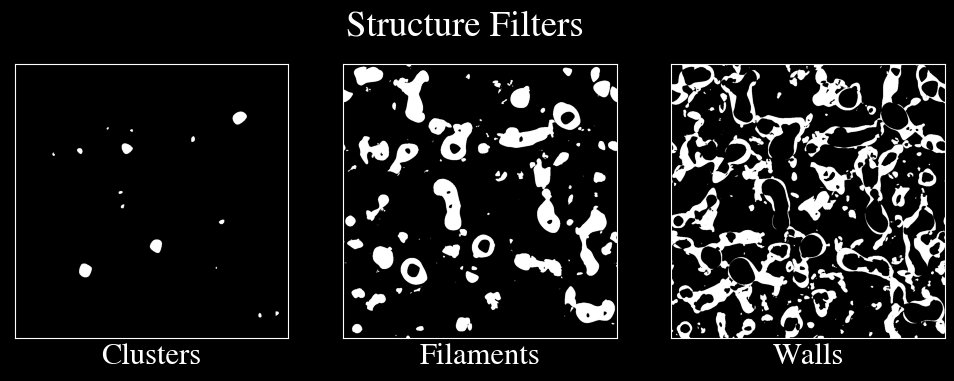

In [5]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
f.suptitle("Structure Filters")
ax1.imshow(clusbool[:,:,300], origin="lower", cmap="Greys_r")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("Clusters")

ax2.imshow(filbool[:,:,300], origin="lower", cmap="Greys_r")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("Filaments")

ax3.imshow(wallbool[:,:,300], origin="lower", cmap="Greys_r")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel("Walls")

plt.show()

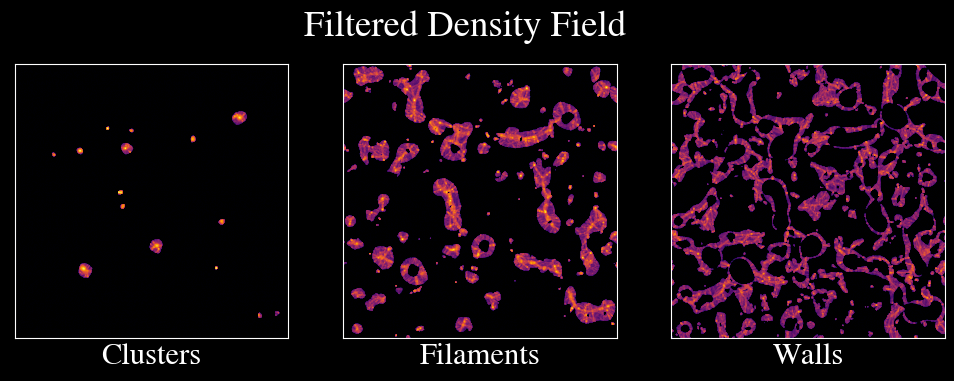

In [7]:

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
f.suptitle("Filtered Density Field")
ax1.imshow(filtered_clus[:,:,300], origin="lower", cmap="inferno",
           norm=mpl.colors.LogNorm(vmin=.001,vmax=1000))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("Clusters")
ax2.imshow(filtered_fil[:,:,300], origin="lower", cmap="inferno",
           norm=mpl.colors.LogNorm(vmin=.001,vmax=1000))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("Filaments")
ax3.imshow(filtered_wall[:,:,300], origin="lower", cmap="inferno",
           norm=mpl.colors.LogNorm(vmin=.001,vmax=1000))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel("Walls")

plt.show()

# Convert to NbodyKit Mesh

In [ ]:
density_mesh = nb.ArrayMesh(density_cube, BoxSize=config["xmax"])
del density_cube

clus_NEXUS_mesh = nb.ArrayMesh(filtered_clus, BoxSize=config["xmax"])
del filtered_clus

fil_NEXUS_mesh = nb.ArrayMesh(filtered_fil, BoxSize=config["xmax"])
del filtered_fil

wall_NEXUS_mesh = nb.ArrayMesh(filtered_wall, BoxSize=config["xmax"])
del filtered_wall


# Compute Power Spectra

In [ ]:
result_all = nb.FFTPower(density_mesh, mode='1d')
result_NEXUS_clus = nb.FFTPower(clus_NEXUS_mesh, mode='1d')
result_NEXUS_fil = nb.FFTPower(fil_NEXUS_mesh, mode='1d')
result_NEXUS_wall = nb.FFTPower(wall_NEXUS_mesh, mode='1d')

pk_all = result_all.power
pk_clus = result_NEXUS_clus.power
pk_fil = result_NEXUS_fil.power
pk_wall = result_NEXUS_wall.power

In [ ]:
for k in pk_all.attrs:
    print("%s = %s" %(k, str(pk_all.attrs[k])))

In [ ]:
plt.figure(figsize=(12,8))
# print the shot noise subtracted P(k)
plt.plot((pk_all['k']) * 1e3, (pk_all['power'].real - pk_all.attrs['shotnoise'])*1e-9, label='All Data', color="white") #Illustris units are kpc we need to convert to Mpc
plt.plot((pk_clus['k']) * 1e3, (pk_clus['power'].real - pk_clus.attrs['shotnoise'])*1e-9, label='NEXUS+ Cluster', color="coral")
plt.plot((pk_fil['k']) * 1e3, (pk_fil['power'].real - pk_fil.attrs['shotnoise'])*1e-9, label='NEXUS+ Filament')
plt.plot((pk_wall['k']) * 1e3, (pk_wall['power'].real - pk_wall.attrs['shotnoise'])*1e-9, label='NEXUS+ Wall')


plt.title("Power Spectra")
# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend(fontsize=14)
# plt.savefig("Images/compare_pk_nexus_quartiles.png", format="png", dpi=300, bbox_inches="tight")
plt.show()